# PINN vs FTCS (part b) – timing and accuracy

Combines the grid sweep from `test_3_PINN_vs_FTCS` with the timing/error checks from `main/final_time_error.ipynb`.
Uses the best PINN from test2 (two layers, 40 nodes, sigmoid).


## Path setup and imports


In [1]:
# Make sure the notebook can import from src/ when run inside code/main_clean
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src import *
from time import perf_counter

# Placeholder for results so later cells can run safely before the loop
test_results = []

import pandas as pd


In [2]:
# Fixed best architecture from test2
architecture = [40, 40]
activation = 'sigmoid'
activation_label = activation

# Training hyperparameters (keep modest for notebook speed)
epochs = 200
learning_rate = 0.01
batch_size = 10
seed = 36

# Training grid
torch.manual_seed(seed)
Nx_train = 30
Nt_train = 30
x_torch_train = torch.linspace(0.0, 1.0, Nx_train)
t_torch_train = torch.linspace(0.0, 1.0, Nt_train)


In [3]:
# Train the PINN and time it
train_start = perf_counter()
P_best, history = train_PINN_pyTorch(x_torch_train,
                                    t_torch_train,
                                    architecture,
                                    epochs,
                                    learning_rate,
                                    activation,
                                    seed,
                                    optimization_method='SGD-adam',
                                    batch_size=batch_size,
                                    shuffle=True,
                                    replacement=False,
                                    verbose=False,
                                    debug=False)
train_time = perf_counter() - train_start
train_final_cost = float(history['cost'][-1]) if history and 'cost' in history else float('nan')
print(f"Training done: {train_time:.3f} s | final cost {train_final_cost:.4e}")


Initial cost:  49.2901725769043
Final cost:  0.0011750536505132914
Training done: 14.099 s | final cost 1.1751e-03


In [4]:
def evaluate_pinn_on_grid(P, x_torch, t_torch, architecture, activation):
    """Run PINN forward pass on a grid, return outputs, max abs error, cost, and runtime."""
    model = Net(network=architecture, activation=activation).to(device)
    model.load_state_dict(P)
    model.eval()
    Nx = len(x_torch)
    Nt = len(t_torch)
    with torch.no_grad():
        start = perf_counter()
        g_dnn = np.zeros((Nx, Nt))
        G_an = np.zeros((Nx, Nt))
        for i, x_ in enumerate(x_torch):
            for j, t_ in enumerate(t_torch):
                point = np.array([x_, t_])
                g_dnn[i, j] = trial_function_pyTorch(x_, t_, model).detach().cpu().numpy()
                G_an[i, j] = g_analytic(point)
        infer_time = perf_counter() - start
    diff = g_dnn - G_an
    max_abs = float(np.max(np.abs(diff)))
    # Cost (requires grad, so rebuild model with grad tracking)
    model_train = Net(network=architecture, activation=activation).to(device)
    model_train.load_state_dict(P)
    cost_val = float(cost_function_pyTorch(x_torch, t_torch, model_train).item())
    return {
        'g_dnn': g_dnn,
        'G_an': G_an,
        'max_abs': max_abs,
        'cost': cost_val,
        'infer_time': infer_time,
    }


In [5]:
# Test grids (matching test_3 style)
Nx_list = [10, 30, 60, 90, 120]
Nt_list = [10, 30, 60, 90, 120]
target_grid = (30, 30)
plot_data = None

# Ensure target grid is included
if target_grid[0] not in Nx_list:
    Nx_list.append(target_grid[0])
if target_grid[1] not in Nt_list:
    Nt_list.append(target_grid[1])

# Keep paired by index; sort by Nx to keep plot ordering stable
pairs = sorted(zip(Nx_list, Nt_list), key=lambda p: p[0])

for idx,(Nx, Nt) in enumerate(pairs):
    x_t = torch.linspace(0.0, 1.0, Nx)
    t_t = torch.linspace(0.0, 1.0, Nt)
    x_np = x_t.detach().cpu().numpy()
    t_np = t_t.detach().cpu().numpy()
    # PINN inference
    pinn_res = evaluate_pinn_on_grid(P_best, x_t, t_t, architecture, activation)
    # FTCS baseline
    ftcs_start = perf_counter()
    ftcs_grid = ftcs_solution(x_np, t_np)
    ftcs_time = perf_counter() - ftcs_start
    G_an_ftcs = np.zeros_like(ftcs_grid)
    for i, x_ in enumerate(x_np):
        for j, t_ in enumerate(t_np):
            G_an_ftcs[i, j] = g_analytic(np.array([x_, t_]))
    ftcs_max_abs = float(np.max(np.abs(ftcs_grid - G_an_ftcs)))
    test_results.append({
        'Nx': Nx,
        'Nt': Nt,
        'pinn_max_abs': pinn_res['max_abs'],
        'pinn_cost': pinn_res['cost'],
        'pinn_infer_time': pinn_res['infer_time'],
        'ftcs_max_abs': ftcs_max_abs,
        'ftcs_time': ftcs_time,
    })
    if (Nx, Nt) == target_grid:
        plot_data = {
            'x': x_np,
            't': t_np,
            'ftcs': ftcs_grid,
            'ftcs_an': G_an_ftcs,
            'pinn': pinn_res['g_dnn'],
        }
    print(f"Nx={Nx}, Nt={Nt} | PINN max abs {pinn_res['max_abs']:.3e}, cost {pinn_res['cost']:.3e}, infer {pinn_res['infer_time']*1e3:.2f} ms | FTCS max abs {ftcs_max_abs:.3e}, time {ftcs_time*1e3:.2f} ms")


Nx=10, Nt=10 | PINN max abs 2.683e-03, cost 1.461e-03, infer 2.97 ms | FTCS max abs 7.486e-03, time 0.37 ms
Nx=30, Nt=30 | PINN max abs 2.946e-03, cost 1.175e-03, infer 23.32 ms | FTCS max abs 7.187e-04, time 3.22 ms
Nx=60, Nt=60 | PINN max abs 2.952e-03, cost 1.099e-03, infer 93.22 ms | FTCS max abs 1.739e-04, time 13.55 ms
Nx=90, Nt=90 | PINN max abs 2.957e-03, cost 1.081e-03, infer 204.52 ms | FTCS max abs 7.653e-05, time 32.59 ms
Nx=120, Nt=120 | PINN max abs 2.956e-03, cost 1.072e-03, infer 363.48 ms | FTCS max abs 2.117e-05, time 58.11 ms


Saved figure to /Users/jennyguldvog/FYS-STK4155-Project-3/code/main_clean/outputs/test3_ftcs_grid_30x30.pdf


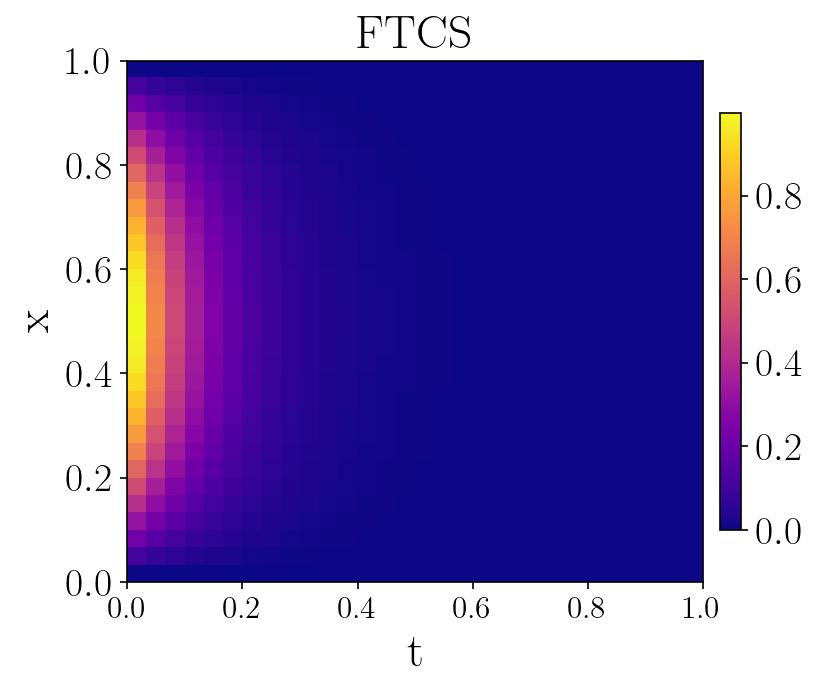

Saved figure to /Users/jennyguldvog/FYS-STK4155-Project-3/code/main_clean/outputs/test3_analytical_grid_30x30.pdf


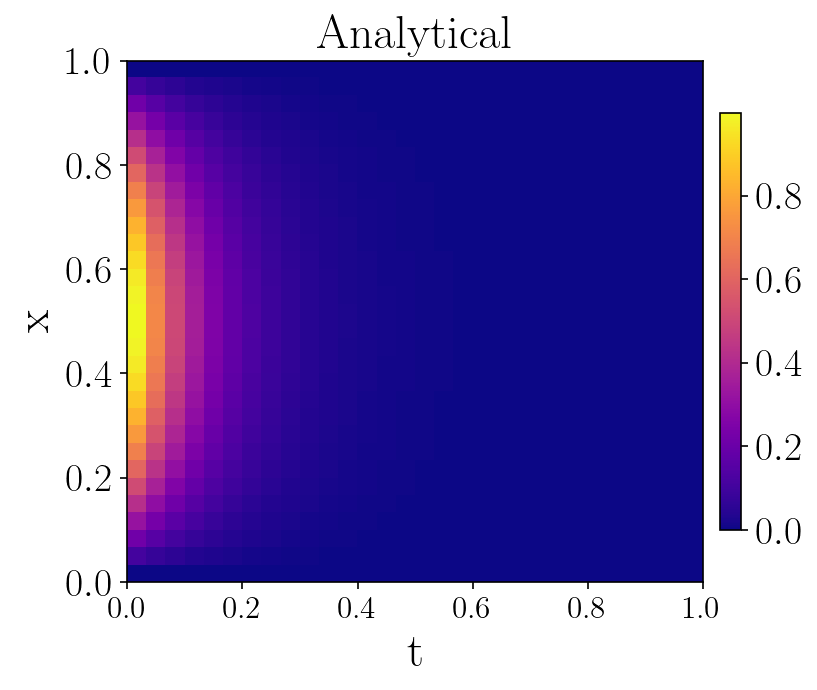

Saved figure to /Users/jennyguldvog/FYS-STK4155-Project-3/code/main_clean/outputs/test3_ftcs_minus_analytical_30x30.pdf


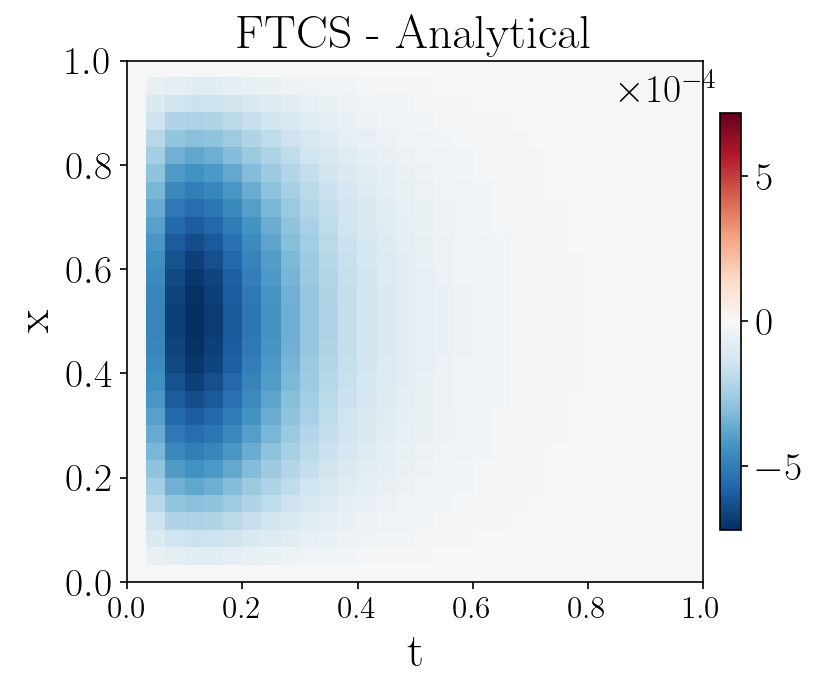

Saved figure to /Users/jennyguldvog/FYS-STK4155-Project-3/code/main_clean/outputs/test3_pinn_minus_ftcs_30x30.pdf


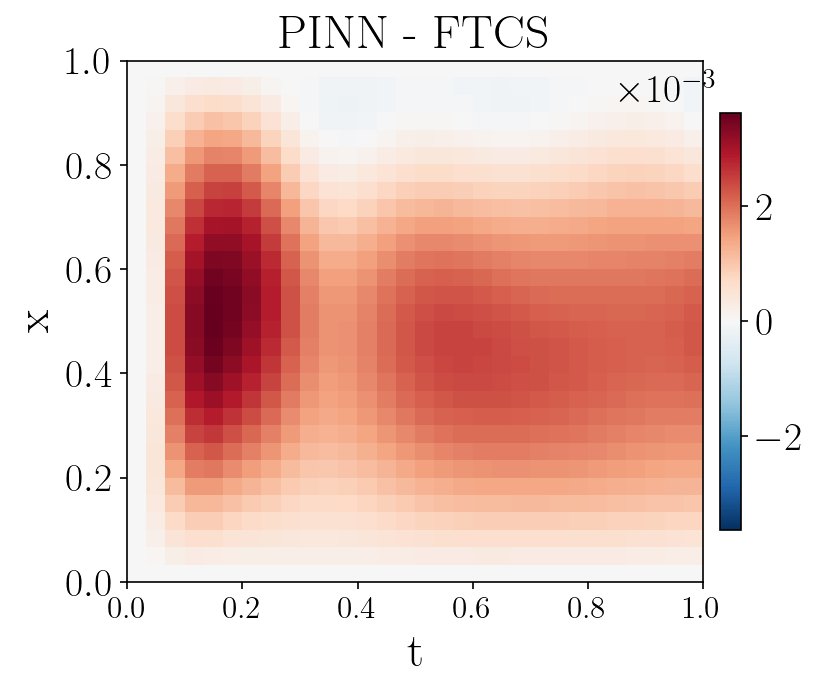

In [6]:

# Heatmaps: FTCS vs analytical and PINN-FTCS (target grid Nx=30, Nt=30)
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

if not plot_data:
    print("plot_data is empty; run the grid loop cell first.")
else:
    x = plot_data['x']
    t = plot_data['t']
    ftcs = plot_data['ftcs']
    ftcs_an = plot_data['ftcs_an']
    pinn = plot_data['pinn']

    def _sci_cbar(fig, im, ax):
        fmt = ScalarFormatter(useMathText=True)
        fmt.set_powerlimits((-2, 2))
        cbar = fig.colorbar(im, ax=ax, shrink=0.8, format=fmt, pad=0.025)
        off = cbar.ax.yaxis.get_offset_text()
        off.set_position((0, 0))  # push outside plot
        off.set_verticalalignment('bottom')
        return cbar

    # FTCS heatmap (no transpose; swap labels only)
    fig_ftcs, ax0 = plt.subplots(figsize=(6,5))
    im0 = ax0.imshow(ftcs, origin='lower', extent=[x.min(), x.max(), t.min(), t.max()], aspect='auto', cmap='plasma')
    ax0.set_title('FTCS')
    ax0.set_xlabel('t')
    ax0.set_ylabel('x')
    _sci_cbar(fig_ftcs, im0, ax0)
    fig_ftcs.tight_layout()
    save_fig('test3_ftcs_grid_30x30', fig=fig_ftcs)
    plt.show()

    # Analytical heatmap
    fig_an, ax1 = plt.subplots(figsize=(6,5))
    im1 = ax1.imshow(ftcs_an, origin='lower', extent=[x.min(), x.max(), t.min(), t.max()], aspect='auto', cmap='plasma')
    ax1.set_title('Analytical')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    _sci_cbar(fig_an, im1, ax1)
    fig_an.tight_layout()
    save_fig('test3_analytical_grid_30x30', fig=fig_an)
    plt.show()

    # FTCS - Analytical
    fig_diff, ax2 = plt.subplots(figsize=(6,5))
    diff_ftcs = ftcs - ftcs_an
    v = float(np.max(np.abs(diff_ftcs))) or 1e-12
    im2 = ax2.imshow(diff_ftcs, origin='lower', extent=[x.min(), x.max(), t.min(), t.max()], aspect='auto', cmap='RdBu_r', vmin=-v, vmax=v)
    ax2.set_title('FTCS - Analytical')
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    _sci_cbar(fig_diff, im2, ax2)
    fig_diff.tight_layout()
    save_fig('test3_ftcs_minus_analytical_30x30', fig=fig_diff)
    plt.show()

    # PINN - FTCS
    fig_pf, ax3 = plt.subplots(figsize=(6,5))
    diff_pf = pinn - ftcs
    v2 = float(np.max(np.abs(diff_pf))) or 1e-12
    im_pf = ax3.imshow(diff_pf, origin='lower', extent=[x.min(), x.max(), t.min(), t.max()], aspect='auto', cmap='RdBu_r', vmin=-v2, vmax=v2)
    ax3.set_title('PINN - FTCS')
    ax3.set_xlabel('t')
    ax3.set_ylabel('x')
    _sci_cbar(fig_pf, im_pf, ax3)
    fig_pf.tight_layout()
    save_fig('test3_pinn_minus_ftcs_30x30', fig=fig_pf)
    plt.show()


In [7]:
# Results table (DataFrame + CSV)
import pandas as pd
if not test_results:
    print("test_results is empty; run the grid loop cell first.")
else:
    df = pd.DataFrame(test_results).copy()
    df['pinn_infer_time_ms'] = df['pinn_infer_time'] * 1e3
    df['ftcs_time_ms'] = df['ftcs_time'] * 1e3
    cols = ['Nx', 'Nt', 'pinn_max_abs', 'pinn_cost', 'pinn_infer_time_ms', 'ftcs_max_abs', 'ftcs_time_ms']
    df = df[cols]
    display(df)


,Nx,Nt,pinn_max_abs,pinn_cost,pinn_infer_time_ms,ftcs_max_abs,ftcs_time_ms
0,10,10,0.002683,0.001461,2.967208,0.007486,0.372584
1,30,30,0.002946,0.001175,23.315291,0.000719,3.222959
2,60,60,0.002952,0.001099,93.216750,0.000174,13.547709
3,90,90,0.002957,0.001081,204.517584,0.000077,32.587125
4,120,120,0.002956,0.001072,363.477584,0.000021,58.111208


Saved figure to /Users/jennyguldvog/FYS-STK4155-Project-3/code/main_clean/outputs/test3_mad_vs_grid.pdf


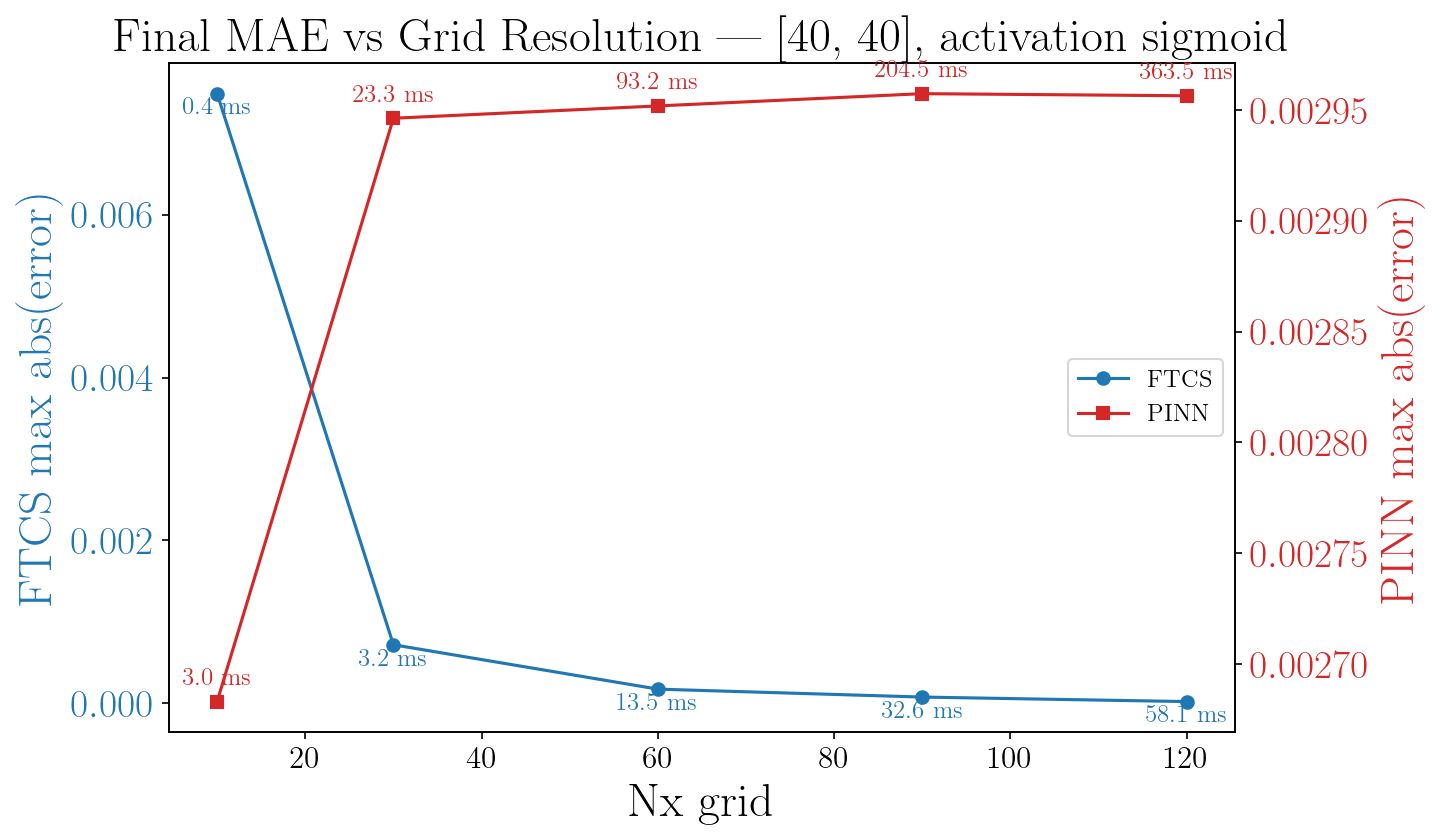

In [11]:
import numpy as np
from collections import OrderedDict

if not test_results:
    print("test_results is empty; run the grid loop cell first.")
else:
    Nx_vals = [r['Nx'] for r in test_results]
    ftcs_mad = [r['ftcs_max_abs'] for r in test_results]
    pinn_mad = [r['pinn_max_abs'] for r in test_results]
    ftcs_time = [r['ftcs_time'] for r in test_results]
    pinn_time = [r['pinn_infer_time'] for r in test_results]

    try:
        x_vals = np.array(Nx_vals, dtype=float)
        xticks = None
    except Exception:
        x_vals = np.arange(len(Nx_vals))
        xticks = Nx_vals

    order = np.argsort(x_vals)
    x_sorted = x_vals[order]
    ftcs_sorted = np.array(ftcs_mad)[order]
    pinn_sorted = np.array(pinn_mad)[order]
    ftcs_time_sorted = np.array(ftcs_time)[order]
    pinn_time_sorted = np.array(pinn_time)[order]

    fig, ax_left = plt.subplots(figsize=(10,6))
    ax_right = ax_left.twinx()

    h1 = ax_left.plot(x_sorted, ftcs_sorted, color='tab:blue', marker='o', linestyle='-', label='FTCS')[0]
    h2 = ax_right.plot(x_sorted, pinn_sorted, color='tab:red', marker='s', linestyle='-', label='PINN')[0]

    for xi, fval, t in zip(x_sorted, ftcs_sorted, ftcs_time_sorted):
        ax_left.annotate(f'{t*1e3:.1f} ms', (xi, fval), textcoords='offset points', xytext=(0,-10), ha='center', fontsize=12, color='tab:blue')
    for xi, pval, t in zip(x_sorted, pinn_sorted, pinn_time_sorted):
        ax_right.annotate(f'{t*1e3:.1f} ms', (xi, pval), textcoords='offset points', xytext=(0,8), ha='center', fontsize=12, color='tab:red')

    ax_left.set_xlabel('Nx grid')
    ax_left.set_ylabel('FTCS max abs(error)', color='tab:blue')
    ax_right.set_ylabel('PINN max abs(error)', color='tab:red')
    ax_left.tick_params(axis='y', labelcolor='tab:blue')
    ax_right.tick_params(axis='y', labelcolor='tab:red')
    if xticks is not None:
        ax_left.set_xticks(x_sorted)
        ax_left.set_xticklabels(xticks)

    by_label = OrderedDict()
    by_label[h1.get_label()] = h1
    by_label[h2.get_label()] = h2
    ax_left.legend(by_label.values(), by_label.keys(), loc='center right')

    plt.title(f'Final MAE vs Grid Resolution — {architecture}, activation {activation_label}')
    plt.tight_layout()
    save_fig('test3_mad_vs_grid')
    plt.show()


In [9]:
# Timing + cost summary
print('=== Training ===')
print(f'PINN training: {train_time:.3f} s | final cost {train_final_cost:.4e} (arch {architecture}, activation {activation_label})')

print('=== Per-grid inference vs FTCS ===')
for r in test_results:
    print(f"Nx={r['Nx']:>3}, Nt={r['Nt']:>3} | PINN infer {r['pinn_infer_time']*1e3:.2f} ms, max|err| {r['pinn_max_abs']:.3e}, cost {r['pinn_cost']:.3e} | FTCS time {r['ftcs_time']*1e3:.2f} ms, max|err| {r['ftcs_max_abs']:.3e}")


=== Training ===
PINN training: 14.099 s | final cost 1.1751e-03 (arch [40, 40], activation sigmoid)
=== Per-grid inference vs FTCS ===
Nx= 10, Nt= 10 | PINN infer 2.97 ms, max|err| 2.683e-03, cost 1.461e-03 | FTCS time 0.37 ms, max|err| 7.486e-03
Nx= 30, Nt= 30 | PINN infer 23.32 ms, max|err| 2.946e-03, cost 1.175e-03 | FTCS time 3.22 ms, max|err| 7.187e-04
Nx= 60, Nt= 60 | PINN infer 93.22 ms, max|err| 2.952e-03, cost 1.099e-03 | FTCS time 13.55 ms, max|err| 1.739e-04
Nx= 90, Nt= 90 | PINN infer 204.52 ms, max|err| 2.957e-03, cost 1.081e-03 | FTCS time 32.59 ms, max|err| 7.653e-05
Nx=120, Nt=120 | PINN infer 363.48 ms, max|err| 2.956e-03, cost 1.072e-03 | FTCS time 58.11 ms, max|err| 2.117e-05
